<center> <img src = https://abohomanbangla.com/AbohomanAdminLogin/left_ad_img/logo-booking-com-png-booking-logo-logotype-3700.png alt="drawing" style="width:900px;"> </center>

# <center> Проект: Проверка и предсказание рейтинга отелей на Booking

In [861]:
#Импортируем все необходимые библиотеки

import pandas as pd
import numpy as np

#Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Импортируем специальный инструмент для разбивки  
from sklearn.model_selection import train_test_split 

#Импортируем библиотеку предупреждений об ошибках
import warnings
warnings.filterwarnings('ignore')

#Импортируем библиотеку для работы с кодировщиком
import category_encoders as ce

In [862]:
#Фиксируем рандомное число (RANDOM_SEED) для воспроизводимости результатов
RANDOM_SEED = 42

#Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

# 0. Постановка задачи 
Есть вероятность, что нечестные отели накручивают себе рейтинг. Необходимо построить модель, которая предсказывает рейтинг отеля для нахождения недобросовестных отелей.

# 1. Сбор и загрузка данных
Данные предоставлены в соревновании на Kaggle. Загружены в папку data.

* _hotels_train.csv_ - набор данных для обучения
* _hotels_test.csv_ - набор данных для оценки качества
* _submission.csv_ - файл сабмишна в нужном формате

## 1.1 Знакомство с данными

In [863]:
#Загружаем датафреймы
df_test = pd.read_csv('data/hotels_test.csv')
df_train = pd.read_csv('data/hotels_train.csv')
df_submission = pd.read_csv('data/submission.csv')

* _hotel_address_ - адрес отеля
* _review_date_ - дата, когда рецензент разместил соответствующий отзыв.
* _average_score_ - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* _hotel_name_ - название отеля
* _reviewer_nationality_ - национальность рецензента
* _negative_review_ - отрицательный отзыв, который рецензент дал отелю.
* _review_total_negative_word_counts_ - общее количество слов в отрицательном отзыв
* _positive_review_ - положительный отзыв, который рецензент дал отелю
* _review_total_positive_word_counts_ - общее количество слов в положительном отзыве
* _reviewer_score_ - оценка, которую рецензент поставил отелю на основе своего опыта
* _total_number_of_reviews_reviewer_has_given_ - количество отзывов, * которые рецензенты дали в прошлом
* _total_number_of_reviews_ - общее количество действительных отзывов об отеле
* _tags_ - теги, которые рецензент дал отелю.
* _days_since_review_ - продолжительность между датой проверки и датой очистки
* _additional_number_of_scoring_ - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* _lat_ - широта отеля
* _lng_ - долгота отеля

In [864]:
display(df_test.head(3))
df_test.info()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [865]:
display(df_train.head(3))
df_train.info()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [866]:
display(df_submission.head(3))
df_submission.info()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [867]:
#Для корректной обработки признаков объединяем train и test в один датасет

#Помечаем данные train
df_train['sample'] = 1 

#Помечаем данные test
df_test['sample'] = 0 

#Так как в тесте нет значений reviewer_score, 
#заполняем его медианным значением из train
df_test['reviewer_score'] = df_train['reviewer_score'].median()

#Объединение
data = pd.concat([df_test, df_train])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515738 entries, 0 to 386802
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 10  r

## 1.2 Вывод
Для корректной обработки признаков объединяем train и test в один датасет. В признаках lat и lng есть пропуски. Датасет состоит из данных с типами: object, int64, float64. Также имеется датасет submission с целевой переменной reviewer_score.

# 2. Очистка данных
Этап очистки необходим для поиска пропусков, дубликатов, а также аномалий в датасете. 

# 2.1 Заполнение пропусков в признаках 'lat' и 'lng'

In [868]:
#Создаем датафрейм с адресами, где нет координат
df_coord = data[data['lat'].isnull()].groupby('hotel_address').count()[['lat', 'lng']]

In [869]:
#Формируем таблицу с координатами
coord = [[48.8399957, 2.3070823], 
           [48.8889127, 2.3309643], 
           [48.8753208, 2.3212033], 
           [41.391552, 2.1757053],
           [48.2208555, 16.3644228],
           [48.233592, 16.3434781],
           [48.2094054, 16.3512565],
           [48.2095525, 16.3492746],
           [48.1888183, 16.381591],
           [48.1868142, 16.418528],
           [41.3749946, 2.1102353],
           [48.219573, 16.2834034],
           [41.3832425, 2.1607609],
           [48.2458909, 16.3397395],
           [48.2135906, 16.3777195],
           [48.2168032, 16.357717],
           [48.220414, 16.3536299]]

In [870]:
#Заносим данные в созданный датафрейм
for i in range(len(df_coord)):
    df_coord.iloc[i] = coord[i]
df_coord

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,48.839996,2.307082
23 Rue Damr mont 18th arr 75018 Paris France,48.888913,2.330964
4 rue de la P pini re 8th arr 75008 Paris France,48.875321,2.321203
Bail n 4 6 Eixample 08010 Barcelona Spain,41.391552,2.175705
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,48.220855,16.364423
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,48.233592,16.343478
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,48.209405,16.351257
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,48.209553,16.349275
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,48.188818,16.381591


In [871]:
#Переносим данные в наш основной датафрейм
data = data.set_index('hotel_address')
data.update(df_coord)
data = data.reset_index()

## 2.2 Разбираем признаки

### Признак 'hotel_address'
Виделим из него страну, a затем закодируем ее.

In [872]:
#Извлекаем страну
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
#Исправляем название страны Kingdom, на United Kingdom
data.loc[data['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'


data['hotel_country'].value_counts()


hotel_country
United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: count, dtype: int64

In [873]:
#Закодируем страны методом OneHotEncoding
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) 
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)


display(data.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lng,sample,reviewer_score,hotel_country,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,hotel_country_France,hotel_country_Austria
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,9.171102,0,8.8,Italy,1,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,4.834443,0,8.8,Netherlands,0,1,0,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,2.161520,0,8.8,Spain,0,0,1,0,0,0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,9.196298,0,8.8,Italy,1,0,0,0,0,0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,4.888644,0,8.8,Netherlands,0,1,0,0,0,0


In [874]:
#Удалим 'hotel_address' и ''hotel_country' так как больше нам не нужны
data = data.drop(['hotel_address', 'hotel_country'], axis = 1)


In [875]:
#Преобразуем review_date в формат datetime и выделяем из даты месяц и год
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=True)

data['month'] = data['review_date'].dt.month

data['year'] = data['review_date'].dt.year

In [876]:
#Создадим функцию для определения сезона
def get_season(date):
    if date in [12, 1, 2]:
        return 'winter'
    if date in [3, 4, 5]:
        return 'spring'
    if date in [6, 7, 8]:
        return 'summer'
    if date in [9, 10, 11]:
        return 'autumn'
    
data['season_of_review'] = data['month'].apply(get_season)

In [877]:
#Кодируем признак сезона 
def get_code_season(season):
    if season is 'winter': 
        return 1
    if season is 'spring': 
        return 2
    if season is 'summer': 
        return 3
    if season is 'autumn': 
        return 4
    
data['season_of_review'] = data['season_of_review'].apply(get_code_season)

In [878]:
#Удаляем признак review_date
data = data.drop(['review_date'], axis = 1)

In [879]:
#Очищаем days_since_review от текста 
data['days_since_review'] = data['days_since_review'].str.extract('(\d+)').astype(int)


In [880]:
display(data.head())

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,reviewer_score,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,hotel_country_France,hotel_country_Austria,month,year,season_of_review
0,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,8.8,1,0,0,0,0,0,7,2017,3
1,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,8.8,0,1,0,0,0,0,12,2016,1
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,8.8,0,0,1,0,0,0,11,2015,4
3,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,...,8.8,1,0,0,0,0,0,10,2015,4
4,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,...,8.8,0,1,0,0,0,0,5,2016,2


In [881]:
data.nunique(dropna=False)

additional_number_of_scoring                     480
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1489
lng                                             1489
sample                                             2
reviewer_score                                    37
hotel_country_Italy                                2
hotel_country_Netherlands                          2
hotel_country_Spain                           

In [882]:
#Убираем признаки которые еще не успели обработать, 
#Модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

<Axes: >

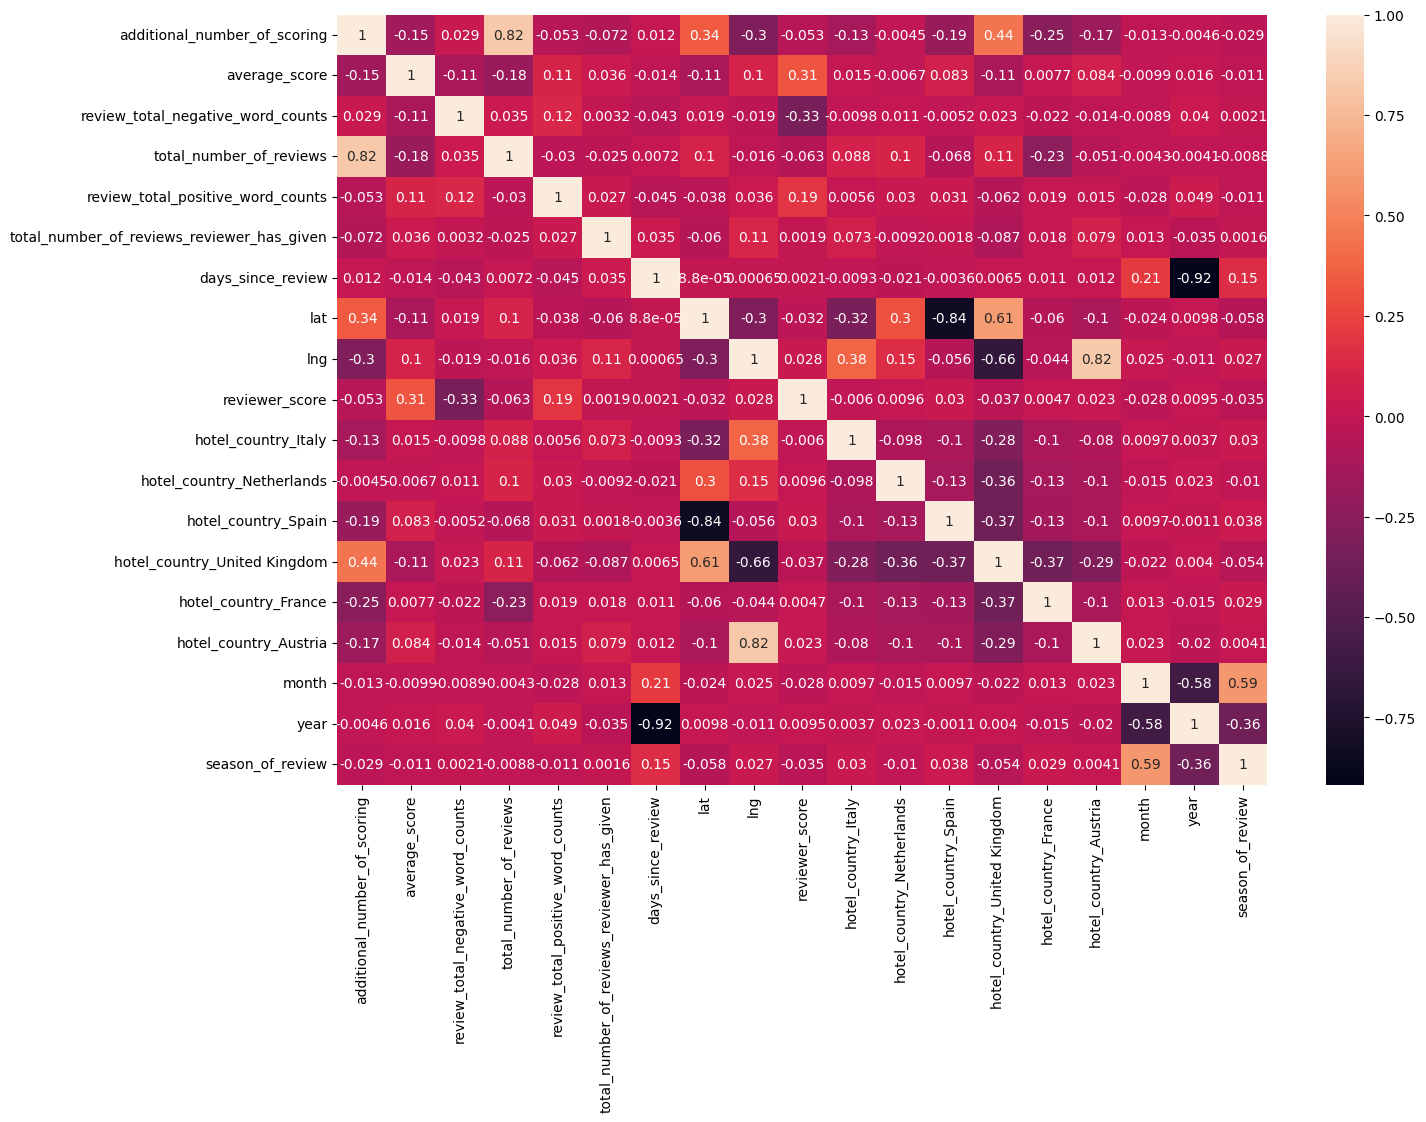

In [883]:
#Создадим тепловую карту
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [884]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int32  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [885]:
#Выделим тестовую часть и тренировочную
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

display(y)

128935    10.0
128936     6.3
128937     7.5
128938    10.0
128939     9.6
          ... 
515733     8.8
515734     9.2
515735     8.3
515736     9.2
515737     8.8
Name: reviewer_score, Length: 386803, dtype: float64

In [886]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 20% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [887]:
#Проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 19), (386803, 19), (386803, 18), (309442, 18), (77361, 18))

In [888]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели


In [889]:
#Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [890]:
#Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

#Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
#Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished


In [891]:
#Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
#Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', (np.abs(y_test - y_pred) / y_test).mean())


MAPE: 0.13780706077745666


<Axes: >

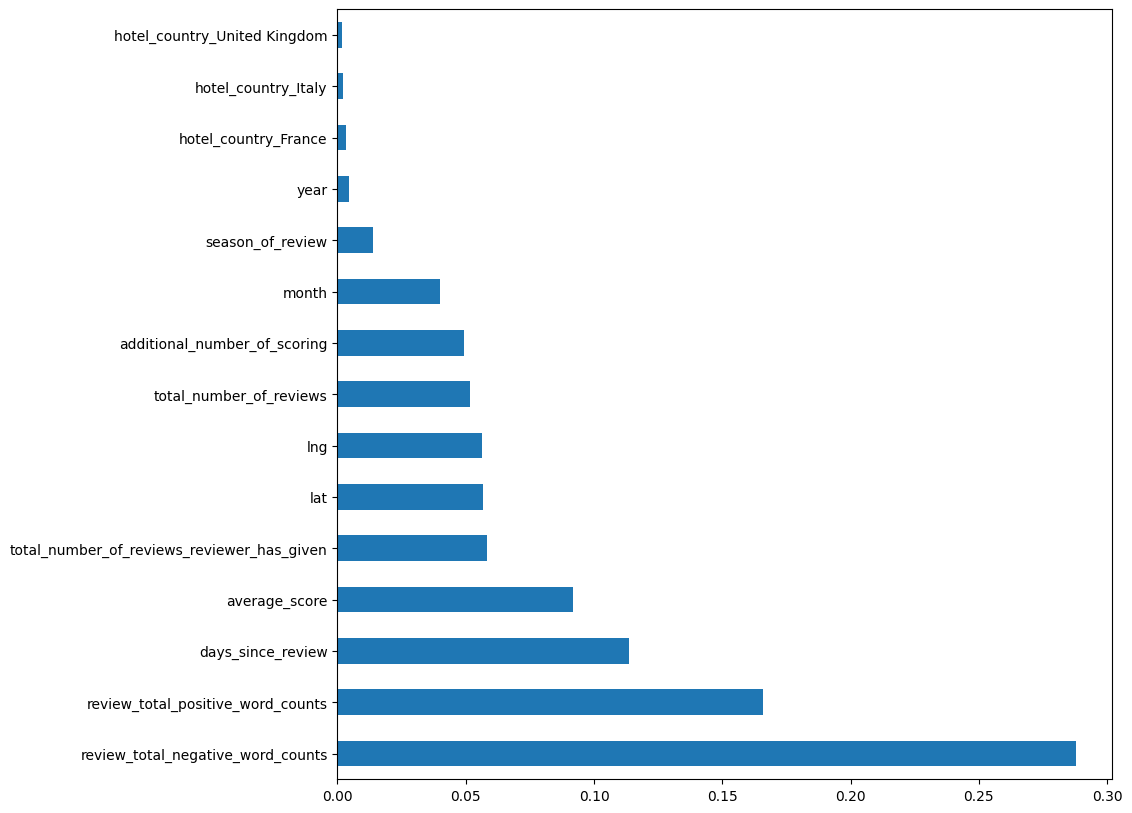

In [892]:
#В RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [893]:
#Посмотрим на структуру test_data
display(test_data.head(5))

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,hotel_country_France,hotel_country_Austria,month,year,season_of_review
0,904,8.1,52,16670,62,1,13,45.533137,9.171102,8.8,1,0,0,0,0,0,7,2017,3
1,612,8.6,10,5018,0,7,234,52.385649,4.834443,8.8,0,1,0,0,0,0,12,2016,1
2,46,8.3,3,351,5,15,616,41.393192,2.161520,8.8,0,0,1,0,0,0,11,2015,4
3,241,9.1,0,1543,27,9,656,45.479888,9.196298,8.8,1,0,0,0,0,0,10,2015,4
4,834,9.1,0,4687,7,2,444,52.370545,4.888644,8.8,0,1,0,0,0,0,5,2016,2


In [894]:
#Удалим из test_data столбец reviewer_score
test_data = test_data.drop(['reviewer_score'], axis=1)

In [895]:
#Итоговое предсказание на тестовых данных датасета
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.5s finished


In [896]:
#Выведем полученный результат итогового предсказания
display(predict_submission)

array([8.667, 7.653, 8.246, ..., 8.312, 9.655, 6.776])

In [897]:
#Заменим значения reviewer_score в df_submission на предсказанные
df_submission['reviewer_score'] = predict_submission
display(df_submission.head(5))

#Создадим csv-файл submission
df_submission.to_csv('data/submission_4.csv', index=False)


,reviewer_score,id
0,8.667,488440
1,7.653,274649
2,8.246,374688
3,9.584,404352
4,9.700,451596
